In [1]:
from JupyterImport import *
from src.DataStandardize.ExpSpecific.Sep20 import Fixes
from src.DatObject.Attributes import SquareEntropy as SE, Transition as T, Entropy as E, DatAttribute as DA, Logs as L
from src.Scripts import SquareEntropyAnalysis as EA
root_logger.setLevel(logging.WARNING)

In [2]:
dat = get_dat(1429)

In [3]:
# dats = get_dats(range(363, 366+1))  # Test Entropy measurements with no Channel Bias, first two 0mT second two -100mT field 100mK
# dats = get_dats(range(368, 373+1))  # Measurements a bit noisy, not quite a full set 100mK, -100mT
# dats = get_dats(range(374, 377+1))  # Accidentally measured 1-> 2 transition 100mK, -100mT
# dats = get_dats(range(378, 384+1))  # 0 -> 1 transition with -0.035 ratio (which turned out to be a bit too high) -100mT field, 100mK
# dats = get_dats(range(385, 389+1))  # 0 -> 1 transition with -0.028 ratio (best from above) -100mT, 100mK
# dats = get_dats(range(488, 517+1))  # Along 0->1 transition starting from gamma broadened, -100mT, 100mK, gamma broadened scans are wider -- Not enough heating
# dats = get_dats(range(518, 547+1))  # Same as above with 5x heating -- Turned out that HQPCs were not set despite the recorded DAC values.
# dats = get_dats(range(581, 595+1))  # Same as above but with working HQPCs and Heating bias set back to +-300mV (~25%)

# dats = get_dats(range(668, 699+1))   # Array of sweep params (computer crashed before finishing)

# dats = get_dats(list(range(815, 848))+list(range(849, 876+1)))  # Array of sweep params (think computer crashed before finising again), Scans are in two parts now (wide then narrow)

# dats = get_dats((1304, 1314+1))

dats = [get_dat(1596)]

save_graphs=False
filter_on = True

In [4]:
for dat in progressbar(dats, redirect_stdout=False):
        if 'LS625 Magnet Supply' in dat.Logs.full_sweeplogs.keys():
            Fixes.fix_magy(dat)
        else:
            dat.Other.magy = L.MAGs(name='magy', field=0, rate='50')
        dat.SquareEntropy.Processed.plot_info.show = SE.ShowPlots(info=True, raw=True, averaged=True, entropy=True)
        dat.SquareEntropy.ShowPlots.integrated = True
dats = [dat for dat in dats if dat.SquareEntropy.Processed.outputs.entropy_fit is not None]

100% (1 of 1) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [5]:
for dat in dats:
    if dat.Logs.fds['LCT'] > -345:  # Force blind averaging for super gamma broadened dats
        print(f'Resetting Square Entropy stuff for Dat{dat.datnum}')
        out = dat.SquareEntropy.Processed.outputs
        inp = dat.SquareEntropy.Processed.inputs
        out.averaged = np.mean(out.cycled, axis=0)
        x = np.linspace(out.x[0], out.x[-1], out.averaged.shape[-1])
        
        fit = E.entropy_fits(x, out.averaged)[0]
        fi = FitInfo.from_fit(fit)
        out.entropy_fit = fi
        dat.SquareEntropy.Processed.outputs = out

In [6]:
recalculate = False
analysis_params = EA.EA_params(bin_data=True, num_per_row=400,
                            sub_line=False, sub_line_range=(-4000, -500),
                            int_entropy_range=(600, 1000),
                            allowed_amp_range=(0.8, 1.2), default_amp=1.05,
                            allowed_dT_range=(1, 15), default_dT=5.06,
                            CT_fit_range=(None, None),
                            fit_param_edit_kwargs=dict())


for dat in progressbar(dats):
    if not hasattr(dat.Other, 'time_processed') or recalculate is True:
        data = EA_data.from_dat(dat)
        values = EA.EA_value()
        EA.calculate_CT_values(data, values, analysis_params)  # Calculates things like dT from transition data. Can change CT_fit_range to fit mostly to inner averaged data for example
        EA.calculate_integrated(data, values, analysis_params)  # Will follow instructions from analysis_params
        EA.calculate_fit(data, values, analysis_params)  # Can add any edit params kwargs here, or uses from analysis_params
        
        if analysis_params.bin_data:
            EA.bin_datas(data, analysis_params.num_per_row)  # Bins data in place (bin because this data is much reduced from fastdac speed due to averaging already)
        
        for dat in pair:
            EA.save_to_dat(dat, data, values, analysis_params)  # Saves everything to DatHDF. Most will be loaded automatically, data needs to be loaded with EA.get_data(dat)
    

N/A% (0 of 1) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

NameError: name 'EA_data' is not defined

In [23]:
# allowed_amps = (0.5, 1.2)
# default_amp = 1
# allowed_dTs = (4.3, 10)
# default_dT = 5.3

# xs, trans_datas, entropy_datas, integrated_datas, ids, trans_titles, entropy_titles, integrated_titles, tcs, ths, dTs = list(), list(), list(), list(), list(), list(), list(), list(), list(), list(), list()
# line = lm.models.LinearModel()
# for dat in progressbar(dats):

#     x = dat.SquareEntropy.Processed.outputs.x
    
#     ids.append(f'{dat.datnum}')
    
#     dat_tcs, dat_amps = list(), list()
#     for data in dat.SquareEntropy.Processed.outputs.averaged[0::2]:
#         fit = T.transition_fits(x, data, func=T.i_sense)[0]
#         dat_tcs.append(fit.best_values['theta'])
#         dat_amps.append(fit.best_values['amp'])
#     dat_ths = list()
#     for data in dat.SquareEntropy.Processed.outputs.averaged[1::2]:
#         fit = T.transition_fits(x, data, func=T.i_sense)[0]
#         dat_ths.append(fit.best_values['theta'])
#     tc = np.nanmean(dat_tcs)
#     th = np.nanmean(dat_ths)
#     dT = th-tc
#     tcs.append(tc)
#     ths.append(th)
#     dTs.append(dT)
    
#     amp = dat.Transition.avg_fit.best_values.amp
    
    
#     if allowed_amps[0] < amp < allowed_amps[1] and allowed_dTs[0] < dT < allowed_dTs[1] and True:
#         amp = np.average(dat_amps)
#         dat.SquareEntropy.Processed.inputs.dT = dT
#         dat.SquareEntropy.Processed.inputs.transition_amplitude = amp
#         dat.SquareEntropy.process()
#         integrated_data = dat.SquareEntropy.Processed.outputs.integrated_entropy
# #         indexs = CU.get_data_index(x, [-1500, -1000])
# #         line_fit = line.fit(integrated_data[indexs[0]:indexs[1]], x=x[indexs[0]:indexs[1]], nan_policy='omit')
# #         integrated_data = integrated_data-line_fit.eval(x=x)
#     else:  # Manually calculate integrated (processing will mess up stuff)
#         out = dat.SquareEntropy.Processed.outputs
#         dx = np.mean(np.diff(x))
#         dt = default_dT
#         amp = amp if allowed_amps[0] < amp < allowed_amps[1] else default_amp
#         out.entropy_signal = SE.entropy_signal(out.averaged)
#         sf = SE.scaling(dt=dt, amplitude=amp, dx=dx)
#         int_info = SE.IntegratedInfo(dT=dt, amp=amp, dx=dx)
#         out.integrated_entropy = SE.integrate_entropy(out.entropy_signal, int_info.sf)
#         int_info.dS = out.integrated_entropy[-1]
#         out.integrated_info = int_info
#         integrated_data = out.integrated_entropy
# #         indexs = CU.get_data_index(x, [-4500, -2500])
# #         line_fit = line.fit(integrated_data[indexs[0]:indexs[1]], x=x[indexs[0]:indexs[1]], nan_policy='omit')
# #         integrated_data = integrated_data-line_fit.eval(x=x)
    
    
#     e_signal = dat.SquareEntropy.Processed.outputs.entropy_signal
#     e_pars = CU.edit_params(dat.SquareEntropy.Processed.outputs.entropy_fit.params, 'const', 0, True)
#     efit = E.entropy_fits(x, e_signal, params=e_pars)[0]
#     efit_info = DA.FitInfo()
#     efit_info.init_from_fit(efit)
    
#     td = dat.SquareEntropy.Processed.outputs.averaged
#     ed = [efit_info.eval_fit(x=x), e_signal]
#     intd = integrated_data
#     if filter_on is True:
#         scan_freq = dat.Logs.Fastdac.measure_freq/dat.AWG.info.wave_len
#         num_steps = dat.AWG.info.num_steps
#         decimate_factor = int(np.floor(num_steps/200))
#         if decimate_factor >= 2:
#             td = CU.decimate(td, scan_freq, decimate_factor=decimate_factor)
#             x = np.linspace(x[0], x[-1], td.shape[-1])
#             ed = [efit_info.eval_fit(x=x), CU.decimate(ed[1], scan_freq, decimate_factor=decimate_factor)]
#             intd = CU.decimate(intd, scan_freq, decimate_factor=decimate_factor)
#         else:
#             pass  # Decimate factor must be 2 or more
#     else:
#         pass
#     xs.append(x)
#     trans_datas.append(td)
#     entropy_datas.append(ed)
#     integrated_datas.append(intd)
    
#     channel_ratio = round(dat.AWG.AWs[1][0][1]/dat.AWG.AWs[0][0][1]/-0.028, 2)
#     dsp = dat.SquareEntropy.Processed
#     ii = dsp.outputs.integrated_info
#     fit_text = f'SF={ii.sf:.2f}, Amp={ii.amp:.3f}nA, T_cold={tc:.3f}mV, T_hot={th:.3f}mV, dT={dT:.3f}mV, fit_dS={efit_info.best_values.dS:.3f}kB'
#     scan_text = f'HQPCbiases=({dat.AWG.AWs[0][0][1]:.0f}mV, {dat.AWG.AWs[0][0][3]:.0f}mV), Channel Biases=({dat.AWG.AWs[1][0][1]:.1f}mV, {dat.AWG.AWs[1][0][3]:.1f}mV), Perp Field={dat.Other.magy.field:.1f}mT'
#     array_text = f'Channel Bias Ratio = {channel_ratio}, Square Wave Frequency = {scan_freq:.1f}Hz, Sweeprate (LP*200) = {dat.Logs.sweeprate:.1f}mV/s'
#     text_info = f'{array_text}<br>{scan_text}<br>{fit_text}'
#     trans_titles.append(f'Dat{dat.datnum}: Averaged CS data<br>{text_info}')
#     entropy_titles.append(f'Dat{dat.datnum}: Entropy data with fit<br>{text_info}')
#     integrated_titles.append(f'Dat{dat.datnum}: Integrated Entropy data<br>{text_info}')
    
    
# fig1 = PlU.get_figure(datas=trans_datas, xs=xs, ids=ids, titles=trans_titles, labels=['v0_0', 'vp', 'v0_1', 'vm'], xlabel=f'{dat.Logs.x_label}', ylabel='Current /nA', plot_kwargs={'mode':'lines+markers'})
# fig2 = PlU.get_figure(datas=entropy_datas, xs=xs, ids=ids, titles=entropy_titles, labels=['fit', 'data'], xlabel=f'{dat.Logs.x_label}', ylabel='Current /nA', plot_kwargs={'mode':'lines+markers'})
# fig3 = PlU.get_figure(datas=integrated_datas, xs=xs, ids=ids, titles=integrated_titles, xlabel=f'{dat.Logs.x_label}', ylabel='Entropy /kB', plot_kwargs={'mode':'lines+markers'})

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--WARNING:src.DatObject.Attributes.Transition:LinAlgError encountered, retrying
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:02WARNING:src.DatObject.Attributes.Transition:LinAlgError encountered, retrying
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:02WARNING:src.DatObject.Attributes.Transition:LinAlgError encountered, retrying
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:01WARNING:src.DatObject.Attributes.Transition:LinAlgError encountered, retrying
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:01WARNING:src.DatObject.Attributes.Transition:LinAlgError encountered, retrying
 63% (7 of 11) |###############          | Elapsed Time: 0:00:01 ETA:   0:00:00WARNING:src.DatObject.Attributes.Transition:LinAlgError encountered, retrying
 72% (8 of 11) |##################       | Elapsed Time: 0

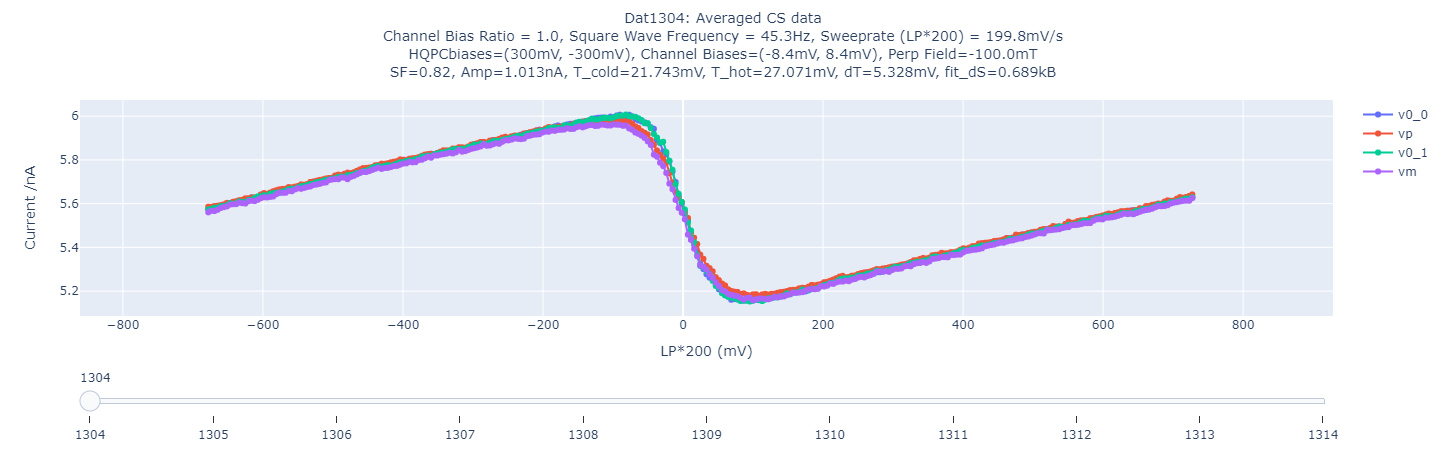

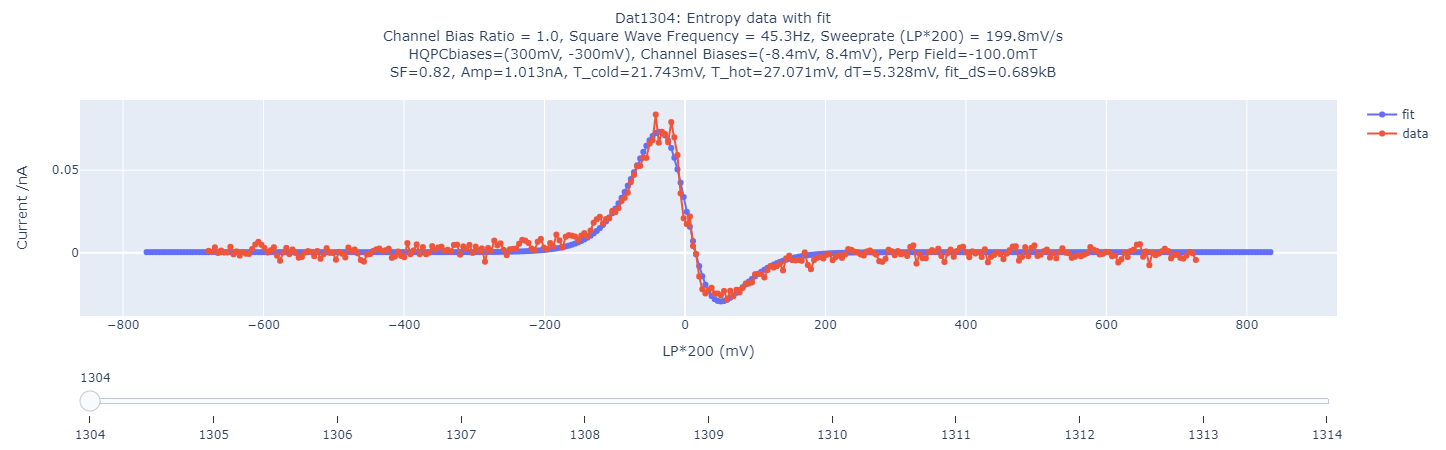

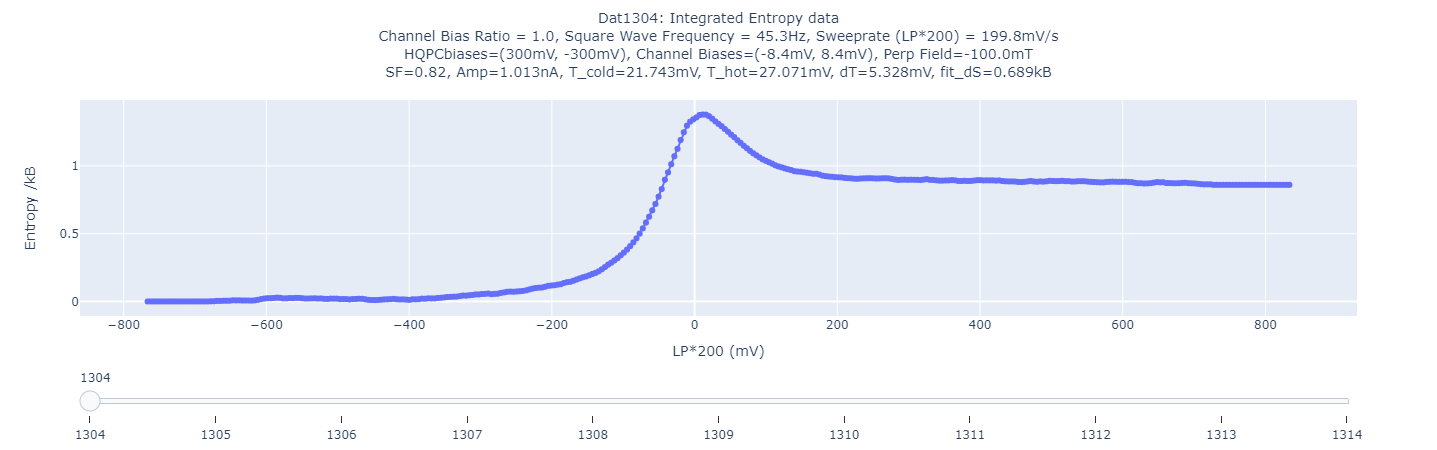

In [24]:
save_graphs=save_graphs
for fig, name in zip([fig1, fig2, fig3], ['AveragedCS_vs_Channel_bias', 'Average_Entropy_With_Fit', 'Averaged_Integrated_Entropy']):
    fig.update_layout(hovermode = 'x unified',
                     title=dict(y=0.95,x=0.5,xanchor='center',yanchor='top', font=dict(size=14)))
    if save_graphs: 
        fig.write_html(export_path+f'Dats{dats[0].datnum}-{dats[-1].datnum}{name}.html')
    fig.show()

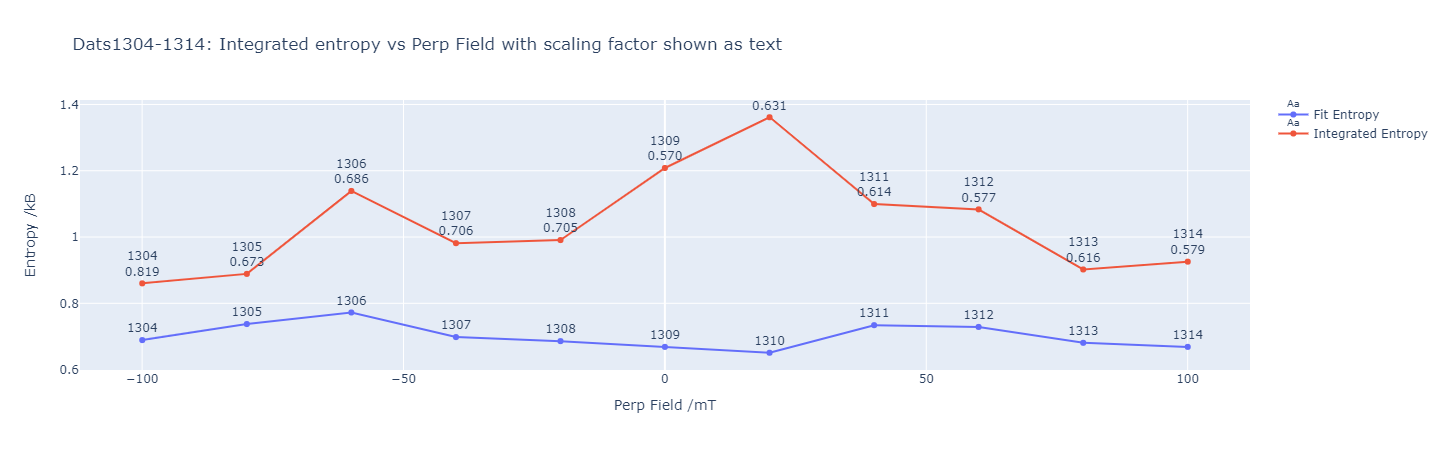

In [25]:
fig = go.Figure()
x_data = 'field'

fit_entropies = list()
for dat in dats:
    x = dat.SquareEntropy.Processed.outputs.x
    e_signal = dat.SquareEntropy.Processed.outputs.entropy_signal
    e_pars = CU.edit_params(dat.SquareEntropy.Processed.outputs.entropy_fit.params, 'const', 0, True)
    efit = E.entropy_fits(x, e_signal, params=e_pars)[0]
    efit_info = DA.FitInfo()
    efit_info.init_from_fit(efit)
    fit_entropies.append(efit_info.best_values.dS)

integrated_entropies = [dat.SquareEntropy.Processed.outputs.integrated_info.dS for dat in dats]

lcts = [dat.Logs.fds['LCT'] for dat in dats]
fields = [dat.Other.magy.field for dat in dats]
sfs = [dat.SquareEntropy.Processed.outputs.integrated_info.sf for dat in dats]
int_texts = [f'{dat.datnum}<br>{sf:.3f}' for dat, sf in zip(dats, sfs)]
fit_texts = [f'{dat.datnum}' for dat in dats]

if x_data == 'LCT':
    x = lcts
    x_title = 'LCT /mV'
    save_name = 'LCT'
elif x_data == 'field':
    x = fields
    x_title = 'Perp Field /mT'
    save_name = 'Perp Field'
fit_trace = go.Scatter(x=x, y=fit_entropies, text=fit_texts, name='Fit Entropy', mode='lines+markers+text')
integrated_trace = go.Scatter(x=x, y=integrated_entropies, text=int_texts, mode='lines+markers+text', name='Integrated Entropy')
fig.add_traces([fit_trace, integrated_trace])
fig.update_layout(xaxis_title=x_title,
                 yaxis_title='Entropy /kB',
                 title=f"Dats{dats[0].datnum}-{dats[-1].datnum}: Integrated entropy vs {save_name} with scaling factor shown as text")
fig.update_traces(textposition='top center')

fig

In [26]:
fig.to_dict()['layout']['xaxis']

{'title': {'text': 'Perp Field /mT'}}

In [27]:
dats = get_dats(range(579, 588+1))  # Weakly coupled dats only
row = 0
xs, datas, amps, thetas, gs = list(), list(), list(), list(), list()
for dat in dats:
    data, f = CU.decimate(dat.Transition.data[row], dat.Logs.Fastdac.measure_freq, numpnts=1000, return_freq=True)
    print(f'Decimating with frequecy = {f}Hz')
    x = CU.get_matching_x(dat.Transition.x, data)  # Makes x array with correct shape
    fit = dat.Transition.all_fits[row]
    amp = fit.best_values.amp
    theta = fit.best_values.theta
    if 'g' in fit.best_values.keys:
        g = fit.best_values.g
        gs.append(g)
    xs.append(x)
    datas.append(data)
    amps.append(amp)
    thetas.append(theta)
    

raw_fig = PlU.get_figure(datas, xs)
avg_fig
fig


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Decimating with frequecy = 66.27717391304348Hz
Decimating with frequecy = 66.27717391304348Hz
Decimating with frequecy = 66.27717391304348Hz
Decimating with frequecy = 66.27717391304348Hz
Decimating with frequecy = 66.27717391304348Hz
Decimating with frequecy = 66.27717391304348Hz
Decimating with frequecy = 66.27717391304348Hz
Decimating with frequecy = 66.27717391304348Hz
Decimating with frequecy = 66.27717391304348Hz
Decimating with frequecy = 66.27717391304348Hz


NameError: name 'avg_fig' is not defined

In [22]:
from src.DatObject.DatHDF import DatHDF
import re
from dictor import dictor

In [ ]:
def combine_dat_parts(xs, datas):
    widths = [abs(x[-1]-x[0]) for x in xs]
    _, xs, datas = list(zip(widths, xs, datas).sort())
    
    final_x = 
    
    
#     of = None
#     part = None
#     for dat in dats:
#         comments = dat.Logs.comments.split(',')
#         for com in comments:
#             if re.search('*part*', com):
#                 part = re.match('(?<=part)\d+')
#                 if of:
#                     assert of == re.match('(?<=of)\d+')
#                 else:
#                     of = re.match('(?<=of)\d+')
#         if part is None:
#             part += 1
#             logger.warning(f'No "part#of#" found, assuming dats are sequential')
        
#         dat.Other.part_of = (part, of)
#         # TODO: Finish this thought... Need to somehow combine the averaged data only probably, and then figure out a good place to save it... Or should this only be a function which returns a certain part of the data? 
        